# Trigonometric time series model

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


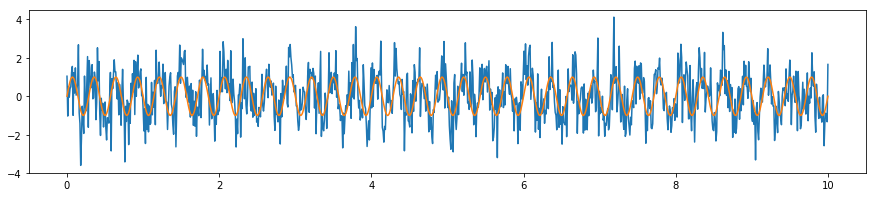

In [2]:
t = np.linspace(0., 10., 1000)
# 3.5Hz sine wave
func = lambda a, b, omega: a*np.sin(2*np.pi*omega*t)+b*np.cos(2*np.pi*omega*t)
y = func(1., 0., 3.5)
data = y + np.random.normal(size = t.shape[0])

_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(t, data)
ax.plot(t, y);

In [3]:
with pm.Model() as model:
    a = pm.Normal("a", mu = 1, sd = 2)
    b = pm.Normal("b", mu = 1, sd = 2)
    omega = pm.Gamma("omega", 1., 1.)
    regression = a*tt.sin(2*np.pi*omega*t) + b*tt.cos(2*np.pi*omega*t)
    sd = pm.HalfCauchy("sd", 0.5)
    observed = pm.Normal("observed", mu = regression, sd = sd, observed = data)

In [51]:
with model:
    step1 = pm.Metropolis([omega])
    trace = pm.sample(10000, tune=5000, step=step1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [omega_log__]
>NUTS: [sd_log__, b, a]
 38%|███▊      | 5686/15000 [00:09<00:15, 615.91it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '12403' (I am process '12404')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
100%|██████████| 15000/15000 [00:26<00:00, 572.09it/s]
The acceptance probability does not match the target. It is 0.7210977198606165, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


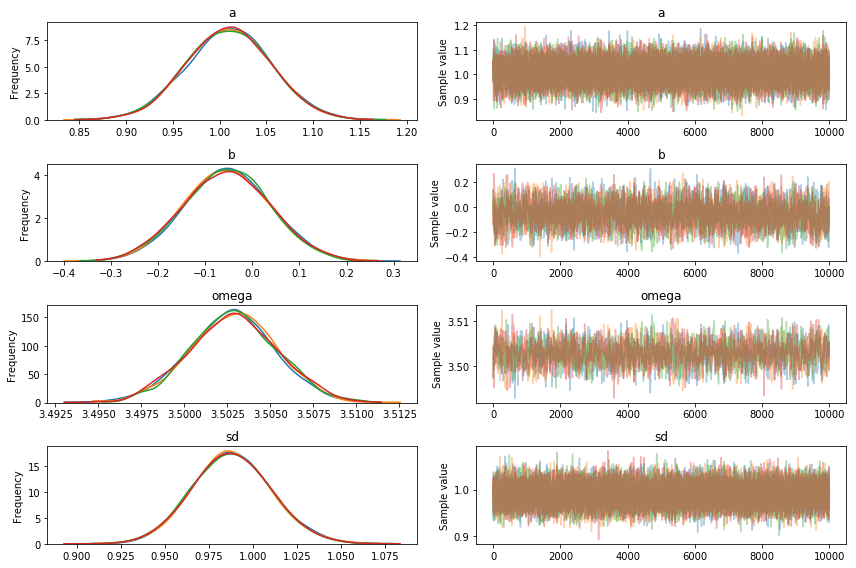

In [52]:
pm.traceplot(trace);

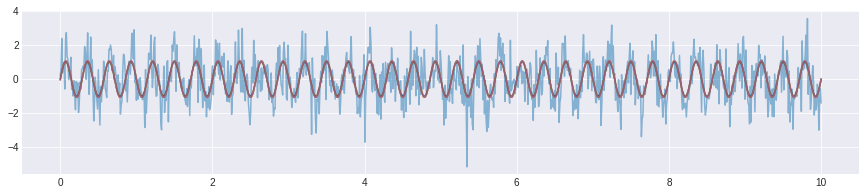

In [85]:
omegapost = trace.get_values(varname='omega', combine=False)
apost = trace.get_values(varname='a', combine=False)
bpost = trace.get_values(varname='b', combine=False)
_, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(t, data, alpha=.5)
ax.plot(t, y, color='k', alpha=.5)
for ia, ib, io in zip(apost, bpost, omegapost):
    y_ = func(ia.mean(), ib.mean(), io.mean())
    ax.plot(t, y_,  alpha=.5);

In [53]:
with model:
    trace2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, omega_log__, b, a]
100%|██████████| 2000/2000 [00:14<00:00, 133.59it/s]
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11562330466472794, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9983968848097133, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9450626207353457, but should be close to 0.8. Try to increase the number of tuning steps.
There were 186 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3946791580373015, but

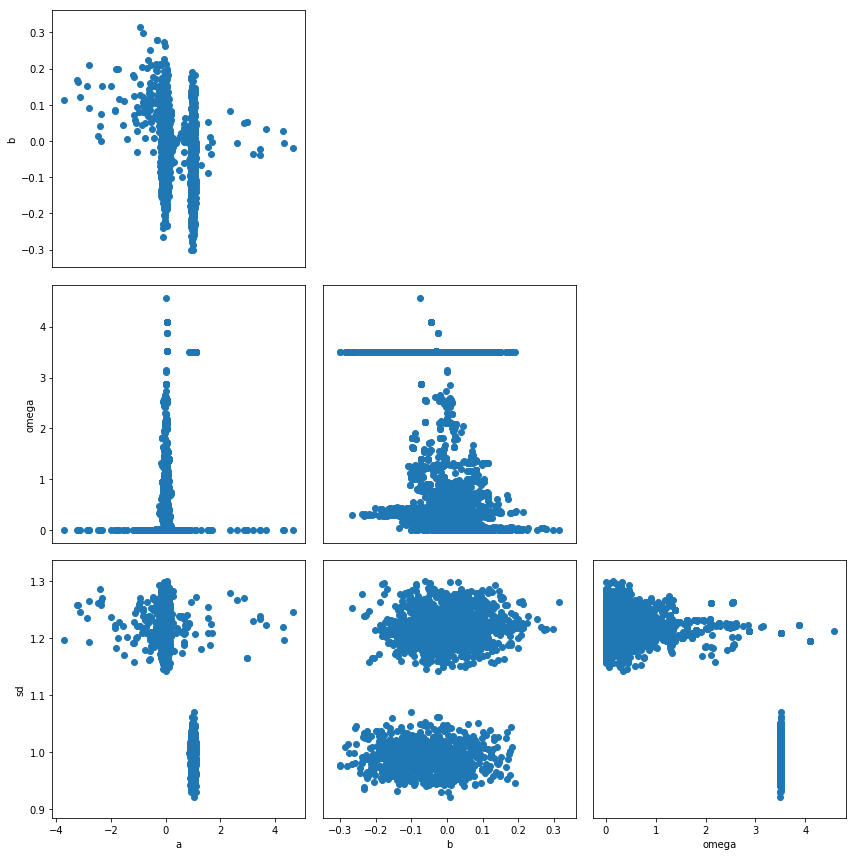

In [54]:
pm.pairplot(trace2, alpha=.05);

In [4]:
model.free_RVs

[a, b, omega_log__, sd_log__]

In [21]:
logp_dlogp_cond = model.logp_dlogp_function([model.free_RVs[0], model.free_RVs[2]])

In [22]:
pt = model.test_point
pt

{'a': array(1.),
 'b': array(1.),
 'omega_log__': array(0.),
 'sd_log__': array(-0.69314718)}

In [47]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(0.5)
logp_dlogp_cond.set_extra_values(pt)

In [48]:
pt['a'] = np.array(2.)
pt

{'a': array(2.),
 'b': array(0.),
 'omega_log__': array(0.),
 'sd_log__': -0.6931471805599453}

In [49]:
logp_dlogp_cond.dict_to_array(pt)

array([2., 0.])

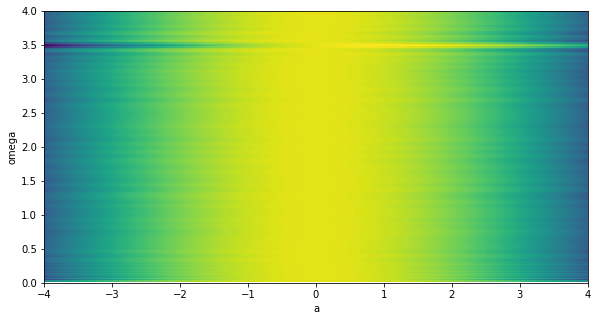

In [72]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, 4, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

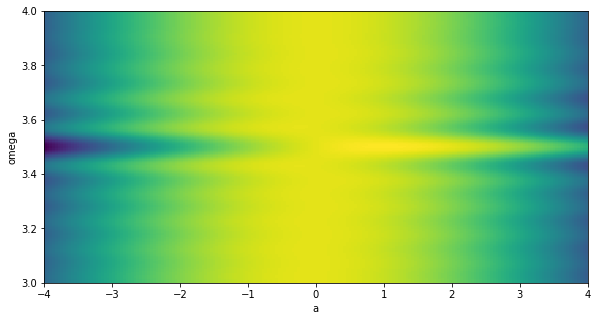

In [73]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(3, 4, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=4, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

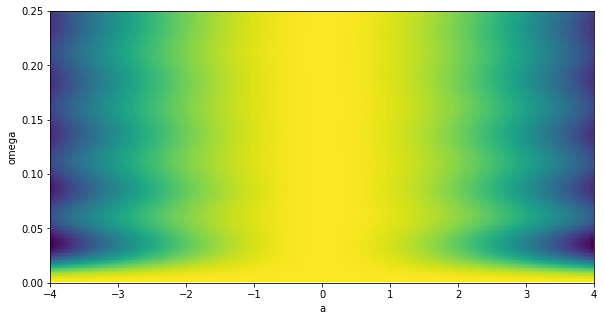

In [71]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, .25, 200)
a_ = np.linspace(-4, 4, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=16, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');

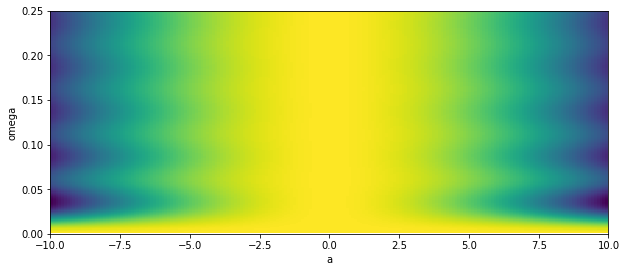

In [74]:
pt['b'] = np.array(0.)
pt['sd_log__'] = np.log(1.)
logp_dlogp_cond.set_extra_values(pt)
# grid search
omega_ = np.linspace(0, .25, 200)
a_ = np.linspace(-10, 10, 200)
ov_, av_ = np.meshgrid(omega_, a_)
logvec = np.asarray([logp_dlogp_cond(np.asarray([a__, np.log(o__)]))[0]
                    for o__, a__ in zip(ov_.flatten(), av_.flatten())])
ll = logvec.reshape(av_.shape)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(ll.T, cmap='viridis',
         extent=[a_[0], a_[-1], omega_[0], omega_[-1]], aspect=16*2, origin='lower'
         )
ax.set_xlabel('a')
ax.set_ylabel('omega');